**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [24]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 500)

#def load_housing_data(housing_path=HOUSING_PATH):
#    csv_path = os.path.join(housing_path, "housing.csv")
#    return pd.read_csv(csv_path)

DATASET_PATH = "datasets/uci/"
def load_uci_data(path):
    csv_path = os.path.join(DATASET_PATH, path)
    return pd.read_csv(csv_path)

In [5]:
#housing = load_housing_data()
#housing.head()

#Otros candidatos a agregar:

# Producto 11: Incidencia por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto11

# Producto 26: Casos nuevos con sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto26

# Producto 27: Casos nuevos sin sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto27

# Producto 38: Casos fallecidos por comuna (usar CasosFallecidosPorComuna_std)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38

# -------------------------------------------------------------------------------

# Producto 8: Pacientes COVID UCI (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto8
uci_region = load_uci_data("UCI_T.csv")

# Producto 19: Casos activos (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto19
casos_activos = load_uci_data("ActivosComuna_std.csv") #Nuevo

# Producto 20: Número de ventiladores
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto20
vent_disp = load_uci_data("NumeroVentiladores_T.csv")

# Producto 23: Pacientes críticos
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto23
uci_covid_nacional = load_uci_data("PacientesCriticos_T.csv")

# Producto 24: Camas Hospital Diario
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto24
camas = load_uci_data("CamasHospital_Diario_T.csv")

# Producto 35: Comorbilidad
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto35
comorb_nacional = load_uci_data("Comorbilidad_T.csv")

# Producto 37: Defunciones
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto37
defunc_nacional = load_uci_data("Defunciones_T.csv")

# Productos 38: Casos fallecidos por comuna
#https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38
defunc_regional = load_uci_data("CasosFallecidosComuna_std.csv")   

# Producto 44: Evolución semanal de egresos hospitalarios pacientes COVID-19
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto44
egresos_nacional = load_uci_data("Egresos_std.csv") #Nuevo

# Producto 52: Camas Hospital (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto52
camas_region = load_uci_data("CamasHospital_Regional_std.csv")

## Limpieza de datos

In [6]:
comorb_nacional.columns

Index(['Comorbilidad', 'Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica', 'Hipertensión arterial.1', 'Diabetes.1',
       'Obesidad.1', 'Asma.1', 'Enfermedad cardiovascular.1',
       'Enfermedad pulmonar crónica.1', 'Cardiopatía crónica.1',
       'Enfermedad renal crónica.1', 'Enfermedad neurológica crónica.1',
       'Inmunocomprometido.1', 'Enfermedad hepática crónica.1'],
      dtype='object')

In [7]:
camas_region = camas_region[camas_region["Region"].str.match("Metropolitana")]
camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
camas_region = camas_region.pivot_table(index=['Fecha'], columns=['Serie'], values='Casos').fillna(0)
#camas_region.set_index(camas_region["Fecha"], inplace=True)
#camas_region.drop(axis=1, labels="Fecha", inplace=True)
camas_region.drop(axis=1, labels="Camas base (2019)", inplace=True)

camas_region.index.name=None

#Tenemos tambien las camas nacionales, pero es preferible usar las regionales
camas.columns = ['Fecha', 'Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.', 'Camas UCI nac.']
camas.set_index(camas["Fecha"], drop=True, inplace=True)
camas.drop(axis=1, labels=["Fecha"], inplace=True)
camas.index.name = None


comorb_nacional.drop(comorb_nacional.columns[[*range(1,12)]], axis=1, inplace=True)
comorb_nacional.columns = ['Comorbilidad', 'Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica']
comorb_nacional.drop([0],axis=0, inplace=True)
comorb_nacional.set_index(comorb_nacional["Comorbilidad"], drop=True, inplace=True)
comorb_nacional.drop(axis=1, labels=["Comorbilidad"], inplace=True)
comorb_nacional.index.name = None

defunc_nacional = defunc_nacional[["Fecha","Defunciones_2020-07-16"]]
defunc_nacional.columns = ["Fecha", "Defunciones nacional"]
defunc_nacional.set_index(defunc_nacional["Fecha"], inplace=True)
defunc_nacional.drop(axis=1, labels="Fecha", inplace=True)
defunc_nacional.index.name = None

defunc_regional = defunc_regional[4:]
defunc_regional.set_index(defunc_regional["Region"], inplace=True)
defunc_regional = defunc_regional.iloc[:,95:148]
defunc_regional = defunc_regional.apply(pd.to_numeric)
defunc_regional["Defunciones regional"] = defunc_regional.sum(axis=1,numeric_only=True)
defunc_regional.index.name = None
defunc_regional = defunc_regional["Defunciones regional"]

vent_disp.columns = ["Fecha", "Total vent.", "Vent. ocupados", "Vent. disponibles"]
vent_disp.set_index(vent_disp["Fecha"], inplace=True)
vent_disp.drop(axis=1, labels="Fecha", inplace=True)
vent_disp.index.name = None

uci_covid_nacional.columns = ["Fecha", "Pac. criticos nacional"]
uci_covid_nacional.set_index(uci_covid_nacional["Fecha"], inplace=True)
uci_covid_nacional.drop(axis=1, labels="Fecha", inplace=True)
uci_covid_nacional.index.name = None

uci_region = uci_region[["Region", "Metropolitana"]]
uci_region.columns = ["Fecha", "Casos diarios region"]
uci_region.drop([0,1],axis=0, inplace=True)
uci_region.set_index(uci_region["Fecha"], inplace=True)
uci_region.drop(axis=1, labels="Fecha", inplace=True)
uci_region.index.name = None

#casos_activos = casos_activos.rename(columns = {'Casos activos':'Casos activos region'})
casos_activos = casos_activos.loc[:,["Region", "Fecha", "Casos activos"]]
casos_activos.columns = ["Region", "Fecha", "Casos activos region"]
casos_activos = casos_activos[casos_activos["Region"].str.match("Metropolitana")]
casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()
casos_activos.set_index(casos_activos["Fecha"], inplace=True)
casos_activos.drop(axis=1, labels="Fecha", inplace=True)
casos_activos.index.name=None

# Este requiere tratamiento
#egresos_nacional = egresos_nacional[["Fecha Publicación", "Egresos"]]
#egresos_nacional.set_index(egresos_nacional["Fecha Publicación"],inplace=True)
#egresos_nacional.drop(axis=1, labels="Fecha Publicación", inplace=True)
#egresos_nacional.index.name = None



#camas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

#amas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

<ipython-input-7-7d6706d812f5>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
<ipython-input-7-7d6706d812f5>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()


In [8]:
comorb_nacional.columns

Index(['Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica'],
      dtype='object')

In [9]:
data = pd.merge(camas, comorb_nacional, how='outer',left_index=True, right_index=True)
data = pd.merge(data, camas_region, how='outer', left_index=True, right_index=True)
data = pd.merge(data, defunc_nacional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, defunc_regional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, vent_disp,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_covid_nacional,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_region,how='outer', left_index=True, right_index=True)
data = pd.merge(data, casos_activos,how='outer', left_index=True, right_index=True)

data = data.loc['2020-04-14':]
data.index = pd.to_datetime(data.index)
for col in data:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [10]:
#uci_region
# VER UMBRAL y proporción de NaNs
#data.columns
data_rows = data.shape[0]
nan_proportions = data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()
#nan_proportions
data_non_imputable = nan_proportions.loc[nan_proportions[0] >= 0.15]
data_non_imputable
#type(nan_proportions)

#data1.apply(lambda x: x.interpolate())

# Hacer



,0
Hipertensión arterial,0.748330
Diabetes,0.748330
Obesidad,0.748330
Asma,0.748330
Enfermedad cardiovascular,0.748330
Enfermedad pulmonar crónica,0.748330
Cardiopatía crónica,0.748330
Enfermedad renal crónica,0.748330
Enfermedad neurológica crónica,0.748330
Inmunocomprometido,0.748330


In [11]:
def inputData(colname, df):
    colname=colname + " interp"
    df = df.assign(colname=df.interpolate(method='spline', order=3))
    return df

In [12]:
inputable = nan_proportions.loc[nan_proportions[0] <= 0.15]
inputable

,0
Camas basicas nac.,0.017817
Camas medias nac.,0.017817
Camas UTI nac.,0.017817
Camas UCI nac.,0.017817
Camas UCI habilitadas,0.015590
Camas UCI ocupadas COVID-19,0.015590
Camas UCI ocupadas no COVID-19,0.015590
Total vent.,0.013363
Vent. ocupados,0.013363
Vent. disponibles,0.013363


In [13]:
#data = data.assign(Hipertensión_arterial_interp=data["Hipertensión arterial"].interpolate(method='spline', order=3, inplace=True))

#Columnas con <15% casos faltantes
data["Camas basicas nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas medias nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UTI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI habilitadas"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas COVID-19"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas no COVID-19"].interpolate(method='spline', order=2, inplace=True)

#Columnas con >15% casos faltantes
data["Pac. criticos nacional"].rolling(24, min_periods=1,).median()
data["Hipertensión arterial"].interpolate(method='linear', inplace=True)
data["Diabetes"].interpolate(method='linear', inplace=True)
data["Obesidad"].interpolate(method='linear', inplace=True)
data["Asma"].interpolate(method='linear', inplace=True)
data["Enfermedad cardiovascular"].interpolate(method='linear', inplace=True)
data["Enfermedad pulmonar crónica"].interpolate(method='linear', inplace=True)
data["Cardiopatía crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad renal crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad neurológica crónica"].interpolate(method='linear', inplace=True)
data["Inmunocomprometido"].interpolate(method='linear', inplace=True)
data["Enfermedad hepática crónica"].interpolate(method='linear', inplace=True)
data["Defunciones nacional"].rolling(24, min_periods=1,).median()
data["Defunciones regional"].interpolate(method='linear', inplace=True)
data["Casos activos region"].interpolate(method='spline', order=3, inplace=True)

#data["Pac. criticos nacional"].interpolate(method='time', inplace=True)
#data["Hipertensión arterial"].interpolate(method='time', inplace=True)
#data["Diabetes"].interpolate(method='time', inplace=True)
#data["Obesidad"].interpolate(method='time', inplace=True)
#data["Asma"].interpolate(method='time', inplace=True)
#data["Enfermedad cardiovascular"].interpolate(method='time', inplace=True)
#data["Enfermedad pulmonar crónica"].interpolate(method='time', inplace=True)
#data["Cardiopatía crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad renal crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad neurológica crónica"].interpolate(method='time', inplace=True)
#data["Inmunocomprometido"].interpolate(method='time', inplace=True)
#data["Enfermedad hepática crónica"].interpolate(method='time', inplace=True)
#data["Defunciones nacional"].interpolate(method='time', inplace=True)
#data["Casos activos region"].interpolate(method='time', inplace=True)

#for col in list(inputable.index):
#    print(col)
#    data = inputData(col, data)

In [14]:
data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()

,0
Camas basicas nac.,0.004454
Camas medias nac.,0.004454
Camas UTI nac.,0.004454
Camas UCI nac.,0.004454
Hipertensión arterial,0.091314
Diabetes,0.091314
Obesidad,0.091314
Asma,0.091314
Enfermedad cardiovascular,0.091314
Enfermedad pulmonar crónica,0.091314


In [15]:
data.isnull().sum(axis=1)

2020-04-14    17
2020-04-15    16
2020-04-16    12
2020-04-17    12
2020-04-18    12
2020-04-19    12
2020-04-20    12
2020-04-21    12
2020-04-22    12
2020-04-23    12
2020-04-24    12
2020-04-25    12
2020-04-26    12
2020-04-27    12
2020-04-28    12
2020-04-29    12
2020-04-30    12
2020-05-01    12
2020-05-02    12
2020-05-03    12
2020-05-04    12
2020-05-05    12
2020-05-06    12
2020-05-07    12
2020-05-08    12
2020-05-09    12
2020-05-10    12
2020-05-11    12
2020-05-12    12
2020-05-13    12
2020-05-14    12
2020-05-15    12
2020-05-16    12
2020-05-17    12
2020-05-18    12
2020-05-19    12
2020-05-20    12
2020-05-21    12
2020-05-22    12
2020-05-23    12
2020-05-24    12
2020-05-25     1
2020-05-26     1
2020-05-27     1
2020-05-28     1
2020-05-29     1
2020-05-30     1
2020-05-31     1
2020-06-01     1
2020-06-02     1
2020-06-03     1
2020-06-04     1
2020-06-05     1
2020-06-06     1
2020-06-07     1
2020-06-08     1
2020-06-09     1
2020-06-10     1
2020-06-11    

In [16]:
data = data.loc['2020-06-12':'2021-06-30']

In [17]:
data.isnull().sum(axis=1)

2020-06-12    0
2020-06-13    0
2020-06-14    0
2020-06-15    0
2020-06-16    0
2020-06-17    0
2020-06-18    0
2020-06-19    0
2020-06-20    0
2020-06-21    0
2020-06-22    0
2020-06-23    0
2020-06-24    0
2020-06-25    0
2020-06-26    0
2020-06-27    0
2020-06-28    0
2020-06-29    0
2020-06-30    0
2020-07-01    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
2020-07-11    0
2020-07-12    0
2020-07-13    0
2020-07-14    0
2020-07-15    1
2020-07-16    1
2020-07-17    1
2020-07-18    1
2020-07-19    1
2020-07-20    1
2020-07-21    1
2020-07-22    1
2020-07-23    1
2020-07-24    1
2020-07-25    1
2020-07-26    1
2020-07-27    1
2020-07-28    1
2020-07-29    1
2020-07-30    1
2020-07-31    1
2020-08-01    1
2020-08-02    1
2020-08-03    1
2020-08-04    1
2020-08-05    1
2020-08-06    1
2020-08-07    1
2020-08-08    1
2020-08-09    1
2020-08-10    1
2020-08-11    1
2020-08-12    1
2020-08-

## Visualización de los datos

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [15, 10]

Text(0, 0.5, 'Cantidad camas')

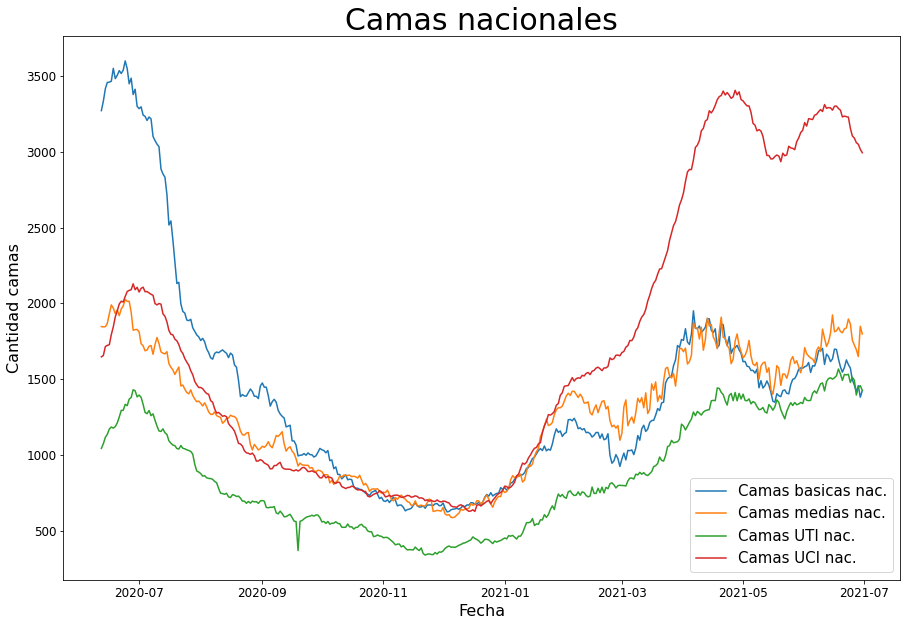

In [20]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data.iloc[:,[0,1,2,3]])
ax1.legend(('Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.',
       'Camas UCI nac.'), fontsize=15 , loc=4)
plt.title("Camas nacionales", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

Text(0, 0.5, 'Cantidad camas')

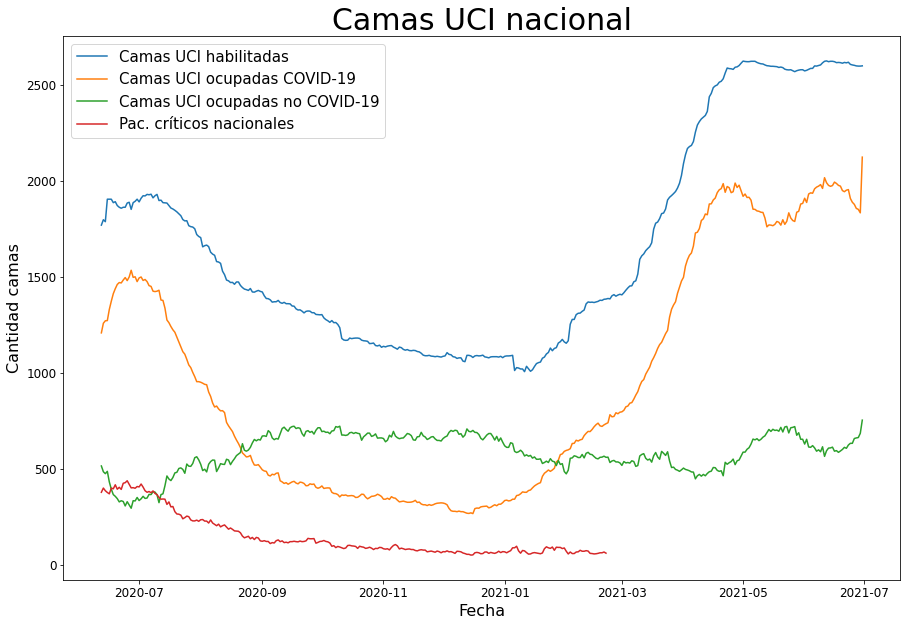

In [21]:
fig, ax2 = plt.subplots(1, 1)
ax2.plot(data.iloc[:,[15,16,17,23]])
ax2.legend(('Camas UCI habilitadas',
       'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19', 'Pac. críticos nacionales'), fontsize=15)
plt.title("Camas UCI nacional", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

Text(0, 0.5, 'Personas con comorbilidad')

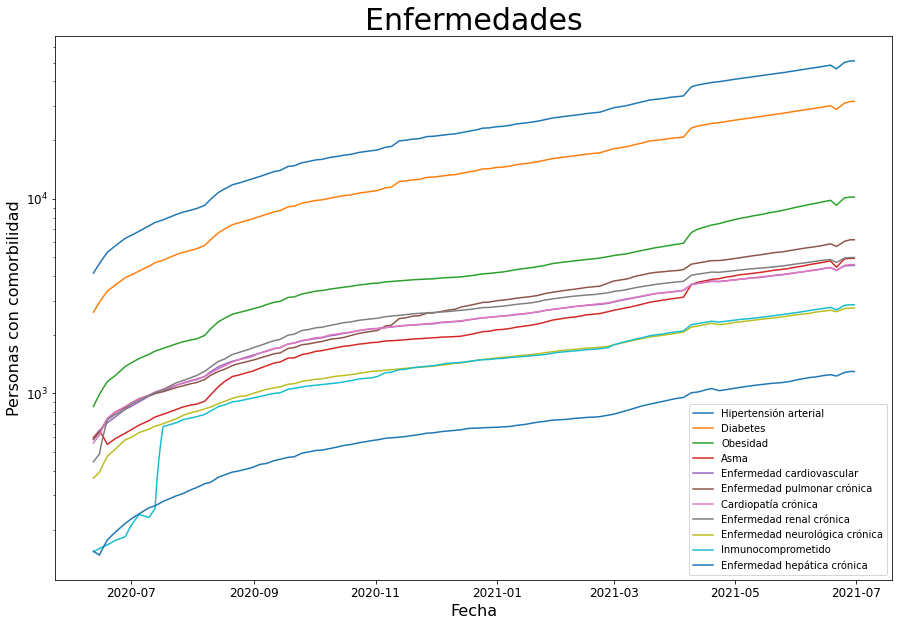

In [22]:
fig, ax3 = plt.subplots(1, 1)
ax3.plot(data.iloc[:,[4,5,6,7,8,9,10,11,12,13,14]])
ax3.legend(('Hipertensión arterial', 'Diabetes', 'Obesidad',
       'Asma', 'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica','Inmunocomprometido',
       'Enfermedad hepática crónica'))
plt.yscale('log')
plt.title("Enfermedades", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Personas con comorbilidad", fontsize=16)

Text(0, 0.5, 'Cantidad ventiladores')

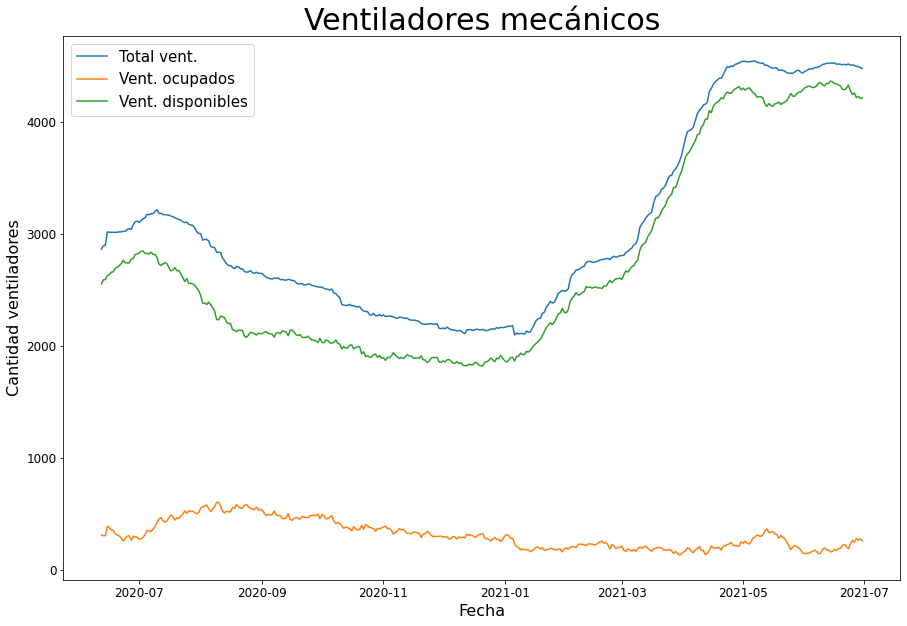

In [23]:
fig, ax4 = plt.subplots(1, 1)
ax4.plot(data.iloc[:,[20,21,22]])
ax4.legend(('Total vent.', 'Vent. ocupados',
       'Vent. disponibles'), fontsize=15)
plt.title("Ventiladores mecánicos", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad ventiladores", fontsize=16)

Text(0, 0.5, 'Casos activos')

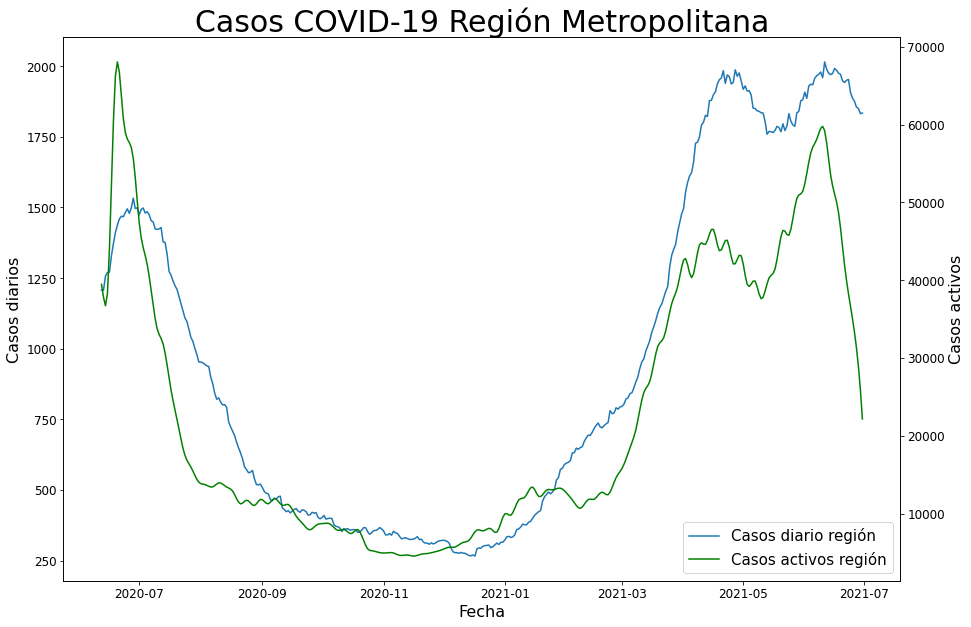

In [24]:
fig, ax5 = plt.subplots(1, 1)
diarios_plot = ax5.plot(data.iloc[:,24])
plt.title("Casos COVID-19 Región Metropolitana", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Casos diarios", fontsize=16)
ax6 = ax5.twinx()
activos_plot = ax6.plot(data.iloc[:,25], color="green")
plot = diarios_plot + activos_plot
ax5.legend(plot, ["Casos diario región", "Casos activos región"], fontsize=15, loc=4)
plt.ylabel("Casos activos", fontsize=16)

Text(0, 0.5, 'Cantidad ventiladores')

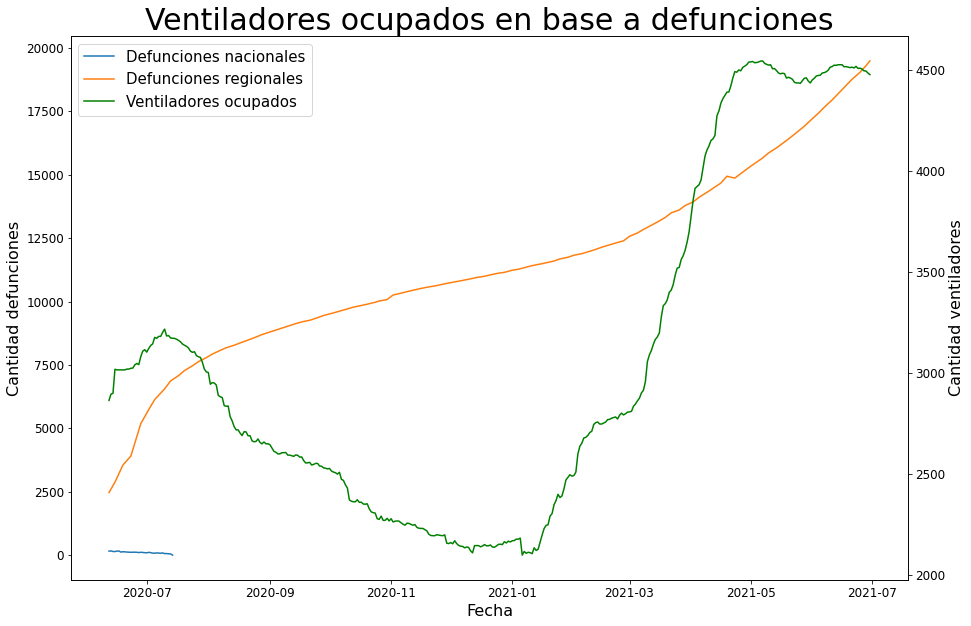

In [25]:
fig, ax7 = plt.subplots(1, 1)
defunciones_plot = ax7.plot(data.iloc[:,[18,19]])
#ax7.legend(('Defunciones', 'Vent. ocupados'), fontsize=15)
plt.title("Ventiladores ocupados en base a defunciones", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad defunciones", fontsize=16)
ax8 = ax7.twinx()
ventiladores_plot = ax8.plot(data.iloc[:,20], color="green")
plot = defunciones_plot + ventiladores_plot
ax8.legend(plot, ["Defunciones nacionales", "Defunciones regionales", "Ventiladores ocupados"], fontsize=15)
plt.ylabel("Cantidad ventiladores", fontsize=16)

## Limpieza de variables
### Se eliminan variables con datos faltantes incluso después de la interpolación.
Candidatos: 
 - Pacientes críticos
 - Defunciones nacional 

In [19]:
data = data.drop(labels=["Pac. criticos nacional", "Defunciones nacional"], axis=1)

Revisando que no queden datos faltantes

In [20]:
data.isnull().sum(axis=1)

2020-06-12    0
2020-06-13    0
2020-06-14    0
2020-06-15    0
2020-06-16    0
2020-06-17    0
2020-06-18    0
2020-06-19    0
2020-06-20    0
2020-06-21    0
2020-06-22    0
2020-06-23    0
2020-06-24    0
2020-06-25    0
2020-06-26    0
2020-06-27    0
2020-06-28    0
2020-06-29    0
2020-06-30    0
2020-07-01    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
2020-07-11    0
2020-07-12    0
2020-07-13    0
2020-07-14    0
2020-07-15    0
2020-07-16    0
2020-07-17    0
2020-07-18    0
2020-07-19    0
2020-07-20    0
2020-07-21    0
2020-07-22    0
2020-07-23    0
2020-07-24    0
2020-07-25    0
2020-07-26    0
2020-07-27    0
2020-07-28    0
2020-07-29    0
2020-07-30    0
2020-07-31    0
2020-08-01    0
2020-08-02    0
2020-08-03    0
2020-08-04    0
2020-08-05    0
2020-08-06    0
2020-08-07    0
2020-08-08    0
2020-08-09    0
2020-08-10    0
2020-08-11    0
2020-08-12    0
2020-08-

## Visualización y análisis de correlación

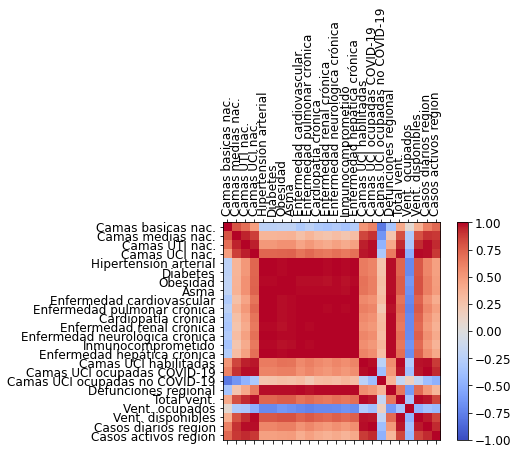

In [25]:
corr = data.corr(method="pearson")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [55]:
corr

,Camas basicas nac.,Camas medias nac.,Camas UTI nac.,Camas UCI nac.,Hipertensión arterial,Diabetes,Obesidad,Asma,Enfermedad cardiovascular,Enfermedad pulmonar crónica,...,Enfermedad hepática crónica,Camas UCI habilitadas,Camas UCI ocupadas COVID-19,Camas UCI ocupadas no COVID-19,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Casos diarios region,Casos activos region
Camas basicas nac.,1.000000,0.794989,0.691557,0.473381,-0.224191,-0.223546,-0.201194,-0.202001,-0.300963,-0.220249,...,-0.280814,0.517963,0.609354,-0.796415,-0.344752,0.415443,0.061681,0.382552,0.610986,0.712323
Camas medias nac.,0.794989,1.000000,0.944689,0.864451,0.346805,0.347294,0.358681,0.364988,0.277774,0.351502,...,0.294391,0.838191,0.902634,-0.642458,0.235570,0.807464,-0.302399,0.802827,0.902638,0.884021
Camas UTI nac.,0.691557,0.944689,1.000000,0.948444,0.507118,0.507799,0.535813,0.532821,0.438682,0.501793,...,0.459460,0.952419,0.981994,-0.470958,0.414660,0.927399,-0.324469,0.918865,0.982511,0.925610
Camas UCI nac.,0.473381,0.864451,0.948444,1.000000,0.722160,0.722135,0.733443,0.739929,0.669690,0.718561,...,0.685567,0.964419,0.978583,-0.319801,0.637937,0.976976,-0.492257,0.989109,0.978411,0.885783
Hipertensión arterial,-0.224191,0.346805,0.507118,0.722160,1.000000,0.999986,0.991389,0.996639,0.995674,0.997801,...,0.997164,0.633649,0.597412,0.249626,0.980779,0.721630,-0.704845,0.778505,0.593025,0.464626
Diabetes,-0.223546,0.347294,0.507799,0.722135,0.999986,1.000000,0.991880,0.996820,0.995482,0.997624,...,0.997031,0.634267,0.597751,0.250752,0.980927,0.722067,-0.703572,0.778738,0.593348,0.465068
Obesidad,-0.201194,0.358681,0.535813,0.733443,0.991389,0.991880,1.000000,0.997323,0.983399,0.981698,...,0.987516,0.672597,0.622794,0.286336,0.979341,0.753303,-0.637573,0.798885,0.618613,0.483347
Asma,-0.202001,0.364988,0.532821,0.739929,0.996639,0.996820,0.997323,1.000000,0.990460,0.989542,...,0.993023,0.666862,0.622432,0.265688,0.977630,0.750855,-0.666967,0.800708,0.618156,0.485928
Enfermedad cardiovascular,-0.300963,0.277774,0.438682,0.669690,0.995674,0.995482,0.983399,0.990460,1.000000,0.993713,...,0.999064,0.573754,0.533189,0.299266,0.986586,0.670252,-0.704160,0.730028,0.528850,0.397792
Enfermedad pulmonar crónica,-0.220249,0.351502,0.501793,0.718561,0.997801,0.997624,0.981698,0.989542,0.993713,1.000000,...,0.994495,0.617362,0.590293,0.217653,0.975323,0.706779,-0.736822,0.769010,0.585831,0.462737


## Preparación de los datos

### Pacientes críticos acumulados a diarios

In [138]:
defunc_ix = list(data.columns).index("Defunciones regional")

In [139]:
X = data.copy()
ind = int(X.shape[0]*0.7)
ind_name = data.index[ind]
ind_name_nxt = data.index[ind+1]
#y_index = list(data.columns).index("Camas UCI ocupadas COVID-19")

y_lab = "Camas UCI nac."

X_train = X.loc[:ind_name, X.columns != y_lab]
X_test = X.loc[ind_name_nxt:, X.columns != y_lab]
y_train = X.loc[:ind_name, "Camas UCI nac."]
y_test = X.loc[ind_name_nxt:, "Camas UCI nac."]

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

#defunc_ix, bedrooms_ix, population_ix, household_ix = [
#    list(housing.columns).index(col)
#    for col in ("total_rooms", "total_bedrooms", "population", "households")]
defunc_ix = list(X_train.columns).index("Defunciones regional")
# = data.iloc[:, defunc_ix]
class DataFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def acum_to_daily(self, X, y=None):
        temp_defunc = X[:, defunc_ix]
        defunc_diario = [temp_defunc[i] - temp_defunc[i-1] for i in range(X.shape[0]-1,0,-1)]
        defunc_diario = np.flip(defunc_diario).tolist()
        defunc_diario[0] = 0
        defunc_diario.append(temp_defunc[X.shape[0]-1])
        X[:,defunc_ix] = defunc_diario
        return X
        #return np.c_[X, defunc_diario]
    def scale_data(self, X, y=None):
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(X)
        return data_scaled

formatter = DataFormatter()


In [141]:
data_prec_train = formatter.acum_to_daily(X_train.values)
data_prec_test = formatter.acum_to_daily(X_test.values)

In [142]:
data_prec_train_norm = formatter.scale_data(data_prec_train)
data_prec_test_norm = formatter.scale_data(data_prec_test)

In [143]:
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

#num_pipeline = Pipeline([
#        ('fix_acum_variables', FunctionTransformer(acum_to_daily, validate=False)),
#        ('std_scaler', StandardScaler()),
#    ])

#data_prec = num_pipeline.fit_transform(data)

In [144]:
x_train = pd.DataFrame(
    data=data_prec_train_norm,
    columns=list(X_train.columns),
    index=X_train.index)

x_test = pd.DataFrame(
    data=data_prec_test_norm,
    columns=list(X_test.columns),
    index=X_test.index)

In [145]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:30:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
6,Asma,0.272921
21,Casos diarios region,0.066555
22,Casos activos region,0.063992
15,Camas UCI ocupadas COVID-19,0.061498
0,Camas basicas nac.,0.060414
1,Camas medias nac.,0.057701
18,Total vent.,0.056906
16,Camas UCI ocupadas no COVID-19,0.054152
3,Hipertensión arterial,0.052864
2,Camas UTI nac.,0.052647


## Eliminar variables correlacionadas

In [159]:
x_train2 = x_train.drop(["Diabetes", "Obesidad", "Enfermedad cardiovascular","Enfermedad hepática crónica", "Enfermedad pulmonar crónica", "Cardiopatía crónica", "Enfermedad renal crónica", "Inmunocomprometido", "Enfermedad neurológica crónica",], axis=1)
x_test2 = x_test.drop(["Diabetes", "Obesidad", "Enfermedad cardiovascular","Enfermedad hepática crónica", "Enfermedad pulmonar crónica", "Cardiopatía crónica", "Enfermedad renal crónica", "Inmunocomprometido", "Enfermedad neurológica crónica",], axis=1)
#corr = x_train2.corr(method="pearson")
#corr

In [160]:
model.fit(x_train2, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train2.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
4,Asma,0.274537
12,Casos diarios region,0.066738
13,Casos activos region,0.064074
6,Camas UCI ocupadas COVID-19,0.061657
0,Camas basicas nac.,0.060270
1,Camas medias nac.,0.057847
9,Total vent.,0.057143
7,Camas UCI ocupadas no COVID-19,0.054588
5,Camas UCI habilitadas,0.053303
2,Camas UTI nac.,0.053176


In [156]:
# Hacer plot de importancia

----

In [161]:

cor_matrix = corr.abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri.iloc[1,:] > 0.90
#print(upper_tri)
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
#print(to_drop)

#data_dropped = x_train.copy()
#data_dropped = data_dropped.drop(to_drop, axis=1)

<ipython-input-161-9a9b2de94927>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


Camas basicas nac.                False
Camas medias nac.                 False
Camas UTI nac.                     True
Hipertensión arterial             False
Camas UCI habilitadas             False
Camas UCI ocupadas COVID-19        True
Camas UCI ocupadas no COVID-19    False
Defunciones regional              False
Total vent.                       False
Vent. ocupados                    False
Vent. disponibles                  True
Casos diarios region               True
Casos activos region              False
Name: Camas medias nac., dtype: bool

In [117]:
data.columns

Index(['Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.',
       'Camas UCI nac.', 'Hipertensión arterial', 'Diabetes', 'Obesidad',
       'Asma', 'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica', 'Camas UCI habilitadas',
       'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19',
       'Defunciones regional', 'Total vent.', 'Vent. ocupados',
       'Vent. disponibles', 'Casos diarios region', 'Casos activos region'],
      dtype='object')

In [118]:
x_train = x_train.drop(["Camas UTI nac.", "Camas UCI habilitadas", "Diabetes", "Obesidad", "Asma", "Enfermedad cardiovascular","Enfermedad pulmonar crónica", "Cardiopatía crónica", "Enfermedad renal crónica", "Enfermedad neurológica crónica", "Inmunocomprometido", "Enfermedad hepática crónica","Camas UCI ocupadas COVID-19", "Camas UCI ocupadas no COVID-19","Total vent.","Vent. disponibles", "Casos diarios region", "Casos activos region"], axis=1)
x_test = x_test.drop(["Camas UTI nac.", "Camas UCI habilitadas", "Diabetes", "Obesidad", "Asma", "Enfermedad cardiovascular","Enfermedad pulmonar crónica", "Cardiopatía crónica", "Enfermedad renal crónica", "Enfermedad neurológica crónica", "Inmunocomprometido", "Enfermedad hepática crónica","Camas UCI ocupadas COVID-19", "Camas UCI ocupadas no COVID-19","Total vent.","Vent. disponibles", "Casos diarios region", "Casos activos region"], axis=1)
corr = to_drop.corr(method="pearson")
corr
#to_drop = x_train[["Enfermedad renal crónica", "Camas UCI nac.", ]]

,Camas basicas nac.,Camas medias nac.,Hipertensión arterial,Defunciones regional,Vent. ocupados
Camas basicas nac.,1.000000,0.912555,-0.748079,0.020045,0.181586
Camas medias nac.,0.912555,1.000000,-0.521098,0.057355,0.044567
Hipertensión arterial,-0.748079,-0.521098,1.000000,0.078148,-0.711411
Defunciones regional,0.020045,0.057355,0.078148,1.000000,-0.088096
Vent. ocupados,0.181586,0.044567,-0.711411,-0.088096,1.000000


# Modelación

In [ ]:
#from sklearn.model_selection import TimeSeriesSplit

#test_size = round(0.25*data.shape[0])
#print(test_size)
#data_x = data.drop("Camas UCI ocupadas COVID-19", axis=1)
#data_y = data["Camas UCI ocupadas COVID-19"].copy()
#split = TimeSeriesSplit(data_x, data_y, test_size=test_size)
#for train_index, test_index in TimeSeriesSplit.split(data_x):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

In [ ]:
#data = strat_train_set.drop("Camas UCI ocupadas COVID-19", axis=1)
#uci = strat_train_set["Camas UCI ocupadas COVID-19"].copy()

## Modelo de regresión lineal

In [ ]:
import sys
!{sys.executable} -m pip install sklearn

In [164]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train2, y_train)

LinearRegression()

In [166]:
linear_predct = lin_reg.predict(x_test2)
print("Predictions:", linear_predct)

Predictions: [ -15.1798266    33.96193367   23.10245324   70.70045259   74.65301205
  128.23415779  139.24222421  174.66988491  257.15692636  247.62867386
  289.52337765  309.7325181   350.85054942  340.30322152  401.88079574
  485.57293361  507.84273895  592.23608189  652.37767628  713.73662819
  725.62306146  819.51423508  893.11339398  947.89803397  955.65919973
 1037.32101888 1032.9519622  1060.17486595 1114.0319465  1246.77291474
 1289.85006904 1311.3029616  1315.60199247 1375.93381776 1364.0066957
 1423.82933001 1452.73121706 1484.76308456 1471.43388686 1465.34499551
 1485.43438988 1498.80995671 1543.79374745 1600.36087583 1602.19497136
 1501.53095497 1503.51664914 1514.14112402 1454.49130432 1462.00770931
 1557.11730051 1536.11557115 1530.95145207 1461.97487206 1415.74941175
 1415.30968493 1397.08147646 1412.91362267 1347.43904114 1283.01909465
 1275.60369293 1261.40158751 1215.06709253 1238.85743672 1223.38318104
 1176.96683658 1122.94794152 1137.1593666  1091.92213429 1054.648

In [167]:
linear_predct = pd.Series(linear_predct)
linear_predct.index = x_test2.index

#print(y_test)
#print(linear_predct.index)
y_test.corr(linear_predct)

data_linear = pd.concat([y_test, linear_predct], axis=1)

Text(0, 0.5, 'UCI ocupadas')

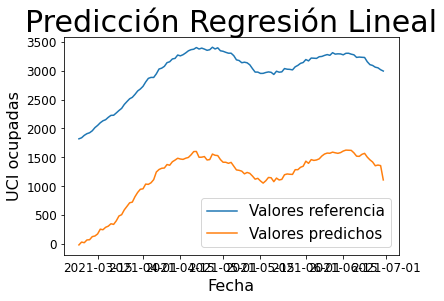

In [168]:
fig, ax4 = plt.subplots(1, 1)
ax4.plot(data_linear)
ax4.legend(('Valores referencia', 'Valores predichos'), fontsize=15)
plt.title("Predicción Regresión Lineal", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("UCI ocupadas", fontsize=16)

In [169]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(y_test, linear_predct)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1804.2439544772421

In [170]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, linear_predct)
lin_mae

1802.7393567156942

In [171]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [172]:
tree_predictions = tree_reg.predict(x_test)
tree_mse = mean_squared_error(y_test, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1748.5681023899676